Notebook for running the project pipeline and experiments separately

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys, os

# Path to the folder where utils.py is located
GOOGLE_DRIVE_PATH = '/content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/'

# Add to Python's import search path
sys.path.append(GOOGLE_DRIVE_PATH)

# Check that utils.py is visible
print("Files in path:", os.listdir(GOOGLE_DRIVE_PATH))

# Now import the helper functions


Mounted at /content/drive
Files in path: ['.git', '.gitignore', 'data', 'environment.yaml', 'scripts', 'README.md', 'project_backup.zip', 'output', 'report_todo.gdoc', '.ipynb_checkpoints', 'comparison_table.csv', 'best_models_overfitting.png', 'run_all.sh']


In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd $GOOGLE_DRIVE_PATH


/content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project


In [5]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
# from scripts.Trans import train_transformer, predict, train_classifier
import matplotlib.pyplot as plt
import os
from pathlib import Path

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [ ]:
# os.chdir(Path().resolve().parent)
print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!python scripts/preprocess.py


=== Running Preprocess Pipeline ===
 Cleaning news data...
/content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/scripts/preprocess.py:86: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["hour"] = df["newsDatetime"].dt.floor("H")
News cleaned: 216456 rows remain.
Saved clean_news.parquet

Loading market data files...
/content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/scripts/preprocess.py:122: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["hour"] = df[ts_col].dt.floor("H")
Loaded 1 market files, total rows = 88683
Saved clean_market.parquet


 Preprocess pipeline complete!


In [ ]:
!python scripts/embedding.py


=== Generating row-level embeddings ===
Found 1 symbols with market data.
Loading model: ProsusAI/finbert on cuda
tokenizer_config.json: 100% 252/252 [00:00<00:00, 1.32MB/s]
config.json: 100% 758/758 [00:00<00:00, 4.62MB/s]
vocab.txt: 232kB [00:00, 62.5MB/s]
special_tokens_map.json: 100% 112/112 [00:00<00:00, 698kB/s]
2025-11-27 06:48:37.263338: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-27 06:48:37.278644: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764226117.296706    3116 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered


In [ ]:
!python scripts/build_features.py --lookback 24


=== Building ML features ===
✔ Found symbols: ['BTC']

--- Processing BTC ---
   BTC: X shape = (13508, 768), y shape = (13508,)

=== Final Dataset Shapes ===
X_all: (13508, 768)
y_all: (13508,)
records: (13508, 3)

 Saved:
 - features/X.npy
 - features/y.npy
 - features/dataset.parquet

 Feature generation completed!


In [ ]:
# ## Test Build features
# import os
# import numpy as np
# import pandas as pd
# from pathlib import Path

# import importlib.util

# spec = importlib.util.spec_from_file_location(
#     "build_features", "scripts/build_features.py"
# )
# build_features = importlib.util.module_from_spec(spec)
# spec.loader.exec_module(build_features)

# # ===== Test Settings =====
# FEATURE_DIR = Path("output/features")
# LOOKBACK = 24
# MODES = ["mean", "volume", "exp_decay", "max", "attn"]


# def run_one_test(mode):
#     print(f"\n\n==============================")
#     print(f"TEST: lookback_mode = {mode}")
#     print(f"==============================")

#     # delete old files
#     for f in ["X.npy", "y.npy", "dataset.parquet"]:
#         fp = FEATURE_DIR / f
#         if fp.exists():
#             fp.unlink()

#     # set args
#     import sys
#     sys.argv = [
#         "build_features.py",
#         "--lookback", str(LOOKBACK),
#         "--lookback-mode", mode,
#     ]

#     # 运行 main()
#     try:
#         build_features.main()
#     except Exception as e:
#         print("Script crashed:", e)
#         return False

#     # check files
#     x_file = FEATURE_DIR / "X.npy"
#     y_file = FEATURE_DIR / "y.npy"
#     df_file = FEATURE_DIR / "dataset.parquet"

#     if not x_file.exists():
#         print("Missing X.npy")
#         return False
#     if not y_file.exists():
#         print("Missing y.npy")
#         return False
#     if not df_file.exists():
#         print("Missing dataset.parquet")
#         return False

#     # load data
#     X = np.load(x_file)
#     Y = np.load(y_file)
#     df = pd.read_parquet(df_file)

#     print("Shapes:", X.shape, Y.shape)

#     if len(X) == 0 or len(Y) == 0:
#         print("Empty X or y!")
#         return False

#     if X.shape[0] != Y.shape[0]:
#         print("X and y length mismatch!")
#         return False

#     if X.ndim != 2:
#         print("X must be 2D")
#         return False

#     if Y.ndim != 1:
#         print("y must be 1D")
#         return False

#     if df.shape[0] != X.shape[0]:
#         print("dataset.parquet row mismatch!")
#         return False

#     print("Files validated OK")
#     return True



# # ===== Run all tests =====
# print("\n=== Running Jupyter Test Suite for build_features.py ===")

# passed = 0

# for m in MODES:
#     ok = run_one_test(m)
#     if ok:
#         print(f"PASS: {m}")
#         passed += 1
#     else:
#         print(f"FAIL: {m}")

# print("\n==============================")
# print(f"Final Summary: {passed}/{len(MODES)} tests passed")
# print("==============================")


In [ ]:
!python scripts/train.py --model lr --seq_len 1 --epochs 30


=== 🚀 Loading Dataset ===
✔ Train: 10806 samples
✔ Val: 2702 samples

=== 🧠 Training LR on cuda ===
Epoch [1/30] Train Loss: 0.001322 | Val Loss: 0.001096
   💾 Saved new best model!
Epoch [2/30] Train Loss: 0.000712 | Val Loss: 0.000802
   💾 Saved new best model!
Epoch [3/30] Train Loss: 0.000540 | Val Loss: 0.000601
   💾 Saved new best model!
Epoch [4/30] Train Loss: 0.000443 | Val Loss: 0.000589
   💾 Saved new best model!
Epoch [5/30] Train Loss: 0.000388 | Val Loss: 0.000494
   💾 Saved new best model!
Epoch [6/30] Train Loss: 0.000341 | Val Loss: 0.000498
Epoch [7/30] Train Loss: 0.000303 | Val Loss: 0.000429
   💾 Saved new best model!
Epoch [8/30] Train Loss: 0.000299 | Val Loss: 0.000381
   💾 Saved new best model!
Epoch [9/30] Train Loss: 0.000257 | Val Loss: 0.000553
Epoch [10/30] Train Loss: 0.000240 | Val Loss: 0.000436
Epoch [11/30] Train Loss: 0.000223 | Val Loss: 0.000370
   💾 Saved new best model!
Epoch [12/30] Train Loss: 0.000210 | Val Loss: 0.000344
   💾 Saved new best 

In [ ]:
!python scripts/predict.py --model lr --seq_len 1


=== Loading dataset for inference ===

=== Predicting with LR on cuda ===
Predicting: 100% 212/212 [00:00<00:00, 731.38it/s]

=== Building results table ===
Saved predictions → output/predictions/predictions_lr.csv
Done! 13508 predictions generated.


In [ ]:
!python scripts//train.py --model transformer --seq_len 12 \
    --model transformer \
    --batch_size 64 \
    --lr 5e-5 \
    --epochs 50 \
    --weight_decay 1e-4 \
    --grad_clip 1.0 \
    --scheduler cosine_warmup \
    --warmup_pct 0.1 \
    --ema_decay 0.995 \
    --seed 42


=== 🚀 Loading Dataset ===
✔ Train: 10795 samples
✔ Val: 2691 samples
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(

=== 🧠 Training TRANSFORMER on cuda ===
Epoch [1/50] Train Loss: 7.174325 | Val Loss: 4.031467
   💾 Saved new best model!
Epoch [2/50] Train Loss: 0.018631 | Val Loss: 0.041719
   💾 Saved new best model!
Epoch [3/50] Train Loss: 0.001425 | Val Loss: 0.005363
   💾 Saved new best model!
Epoch [4/50] Train Loss: 0.001038 | Val Loss: 0.000404
   💾 Saved new best model!
Epoch [5/50] Train Loss: 0.000797 | Val Loss: 0.000197
   💾 Saved new best model!
Epoch [6/50] Train Loss: 0.000632 | Val Loss: 0.000372
Epoch [7/50] Train Loss: 0.000456 | Val Loss: 0.000419
Epoch [8/50] Train Loss: 0.000398 | Val Loss: 0.000153
   💾 Saved new best model!
Epoch [9/50] Train Loss: 0.000348 | Val Loss: 0.000073
   💾 Saved new bes

In [ ]:
!python scripts/predict.py --model transformer --seq_len 12


=== Loading dataset for inference ===
Using sequence length = 12
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(

=== Predicting with TRANSFORMER on cuda ===
Loading EMA shadow weights...
Predicting: 100% 211/211 [00:01<00:00, 205.89it/s]

=== Building results table ===
Saved predictions → output/predictions/predictions_transformer.csv
Done! 13497 predictions generated.


In [ ]:
!python scripts/train.py --model gru --num_layers 3




=== 🚀 Loading Dataset ===
✔ Train: 10816 samples
✔ Val: 2704 samples

=== 🧠 Training GRU on cuda ===
Epoch [1/30] Train Loss: 0.102516 | Val Loss: 0.001167
   💾 Saved new best model!
Epoch [2/30] Train Loss: 0.004280 | Val Loss: 0.000121
   💾 Saved new best model!
Epoch [3/30] Train Loss: 0.001102 | Val Loss: 0.000064
   💾 Saved new best model!
Epoch [4/30] Train Loss: 0.000548 | Val Loss: 0.000047
   💾 Saved new best model!
Epoch [5/30] Train Loss: 0.000312 | Val Loss: 0.000042
   💾 Saved new best model!
Epoch [6/30] Train Loss: 0.000213 | Val Loss: 0.000038
   💾 Saved new best model!
Epoch [7/30] Train Loss: 0.000158 | Val Loss: 0.000037
   💾 Saved new best model!
Epoch [8/30] Train Loss: 0.000123 | Val Loss: 0.000038
Epoch [9/30] Train Loss: 0.000102 | Val Loss: 0.000038
Epoch [10/30] Train Loss: 0.000093 | Val Loss: 0.000038
Epoch [11/30] Train Loss: 0.000080 | Val Loss: 0.000037
   💾 Saved new best model!
Epoch [12/30] Train Loss: 0.000074 | Val Loss: 0.000037
   💾 Saved new best

In [ ]:
!python scripts/evaluate.py --predictions output/predictions/predictions_transformer.csv


=== Linear regression baseline ===

=== Evaluating provided predictions ===
{
  "linear_regression_baseline": {
    "regression_metrics": {
      "mse": 5.031652108300477e-05,
      "rmse": 0.007093413922999614,
      "mae": 0.005218684673309326,
      "mape_pct": 1488.5687255859375,
      "r2": -0.4175746440887451,
      "directional_accuracy": 0.5055514433752776,
      "pearson_ic": 0.021954516850383705,
      "spearman_ic": 0.006139117341810166,
      "precision_up": 0.5138607167004733,
      "recall_up": 0.5519244734931009,
      "precision_down": 0.49550286181520853,
      "recall_down": 0.4573584905660377
    },
    "strategy_metrics": {
      "threshold": 0.0027604219503700733,
      "avg_hourly_return": 6.142899109347341e-05,
      "cumulative_return": 0.15678981071597287,
      "sharpe": 1.4802739247642775,
      "hit_rate": 0.5944487278334618,
      "long_ratio": 0.2853441894892672,
      "short_ratio": 0.19467061435973354,
      "flat_ratio": 0.5199851961509993
    },
    "

In [ ]:
##Check Data used for trainning
df = pd.read_parquet("output/features/dataset.parquet")
df.tail()

,hour,newsTimestamp,return
13503,2025-05-24 03:00:00,2025-05-24 03:35:18,0.001028
13504,2025-05-24 04:00:00,2025-05-24 04:00:27,-0.002183
13505,2025-05-24 05:00:00,2025-05-24 05:41:44,-0.002635
13506,2025-05-24 06:00:00,2025-05-24 06:43:07,-0.003344
13507,2025-05-24 07:00:00,2025-05-24 07:07:14,0.006051


Board Based First Round Tuning (Sub rounds 1-2 are experimental trails, and 3-5 are used as base for the second round)

(Sub)First Round Tuning - 24 hours lookback without changing feature aggregation

In [ ]:
from scripts.hypersearch import HyperSearch

hs = HyperSearch(
    max_runs=2000,
    search_mode="full"   # or "quick"
)
hs.run()

Streaming output truncated to the last 5000 lines.
=== RUN 345 / 2009 ===
Run 345 finished, score=None

=== RUN 346 / 2009 ===
Run 346 finished, score=0.03165411388741761

=== RUN 347 / 2009 ===
Run 347 finished, score=None

=== RUN 348 / 2009 ===
Run 348 finished, score=None

=== RUN 349 / 2009 ===
Run 349 finished, score=None

=== RUN 350 / 2009 ===
Run 350 finished, score=None

=== RUN 351 / 2009 ===
Run 351 finished, score=None

=== RUN 352 / 2009 ===
Run 352 finished, score=0.011282778544891323

=== RUN 353 / 2009 ===
Run 353 finished, score=-9999

=== RUN 354 / 2009 ===
Run 354 finished, score=None

=== RUN 355 / 2009 ===
Run 355 finished, score=None

=== RUN 356 / 2009 ===
Run 356 finished, score=None

=== RUN 357 / 2009 ===
Run 357 finished, score=None

=== RUN 358 / 2009 ===
Run 358 finished, score=-9999

=== RUN 359 / 2009 ===
Run 359 finished, score=None

=== RUN 360 / 2009 ===
Run 360 finished, score=None

=== RUN 361 / 2009 ===
Run 361 finished, score=0.008367686451685223


First Round Tuning Best Model

In [ ]:
import json
## The original file location has been moved to output1128 folder
best_dir = "/content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/output/hyper_runs/run_0103"

with open(best_dir + "/config.json") as f:
    config = json.load(f)
config


{'model': 'gru',
 'seq_len': 8,
 'batch_size': 64,
 'lr': 0.0003,
 'epochs': 30,
 'weight_decay': 0.0,
 'scheduler': None,
 'warmup_pct': 0.1,
 'ema_decay': 0.995,
 'hidden_dim': 512,
 'lstm_proj_dim': 64,
 'tf_d_model': 128,
 'tf_heads': 2,
 'tf_layers': 2,
 'tf_ff_dim': 256,
 'tf_pool': 'attention',
 'tf_dropout': 0.1,
 'cutoff_date': '2024-10-01'}

In [ ]:
!python scripts/train.py \
 --model gru \
 --seq_len 8 \
 --batch_size 64 \
 --lr 0.0003 \
 --epochs 30 \
 --weight_decay 0.0 \
 --warmup_pct 0.1 \
 --ema_decay 0.995 \
 --hidden_dim 512



=== 🚀 Loading Dataset ===
✔ Train: 8615 samples
✔ Val: 2149 samples

=== 🧠 Training GRU on cuda ===
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1393: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1412.)
  result = _VF.gru(
Epoch [1/30] Train Loss: 0.540179 | Val Loss: 0.085038
   💾 Saved new best model!
Epoch [2/30] Train Loss: 0.002735 | Val Loss: 0.015864
   💾 Saved new best model!
Epoch [3/30] Train Loss: 0.000865 | Val Loss: 0.003261
   💾 Saved new best model!
Epoch [4/30] Train Loss: 0.000386 | Val Loss: 0.000586
   💾 Saved new best model!
Epoch [5/30] Train Loss: 0.000205 | Val Loss: 0.000223
   💾 Saved new best model!
Epoch [6/30] Train Loss: 0.000130 | Val Loss: 0.000099
   💾 Saved new best model!
Epoch [7/30]

In [ ]:
!python scripts/predict.py \
 --model gru \
 --seq_len 8 \
 --batch_size 64 \
 --cutoff_date 2024-10-01


=== Loading dataset for inference ===
Using sequence length = 8

=== Predicting with GRU on cuda ===
Loading EMA shadow weights...
Predicting: 100% 211/211 [00:00<00:00, 299.57it/s]

=== Building results table ===
Saved predictions → output/predictions/predictions_gru.csv
Done! 13501 predictions generated.


In [ ]:
!python scripts/evaluate.py \
 --predictions output/predictions/predictions_gru.csv


=== Linear regression baseline ===

=== Evaluating provided predictions ===
{
  "linear_regression_baseline": {
    "regression_metrics": {
      "mse": 0.00012229748244863003,
      "rmse": 0.01105881921583991,
      "mae": 0.007945370860397816,
      "mape_pct": 2148.68359375,
      "r2": -2.663238525390625,
      "directional_accuracy": 0.5064935064935064,
      "pearson_ic": 0.01632480003798929,
      "spearman_ic": 0.009590584685445842,
      "precision_up": 0.5172413793103449,
      "recall_up": 0.3979871912168344,
      "precision_down": 0.49961977186311785,
      "recall_down": 0.6180620884289746
    },
    "strategy_metrics": {
      "threshold": 0.0028360113501548767,
      "avg_hourly_return": 6.161156600946612e-05,
      "cumulative_return": 0.11525585227782131,
      "sharpe": 1.227775225559615,
      "hit_rate": 0.34752267969295186,
      "long_ratio": 0.23098330241187384,
      "short_ratio": 0.4336734693877551,
      "flat_ratio": 0.33534322820037105
    },
    "thresh

(Sub)Second round tuning ++ Feature Aggregation Parameters

In [ ]:
from scripts.hypersearch import HyperSearch

hs = HyperSearch(
    max_runs=30000,
    search_mode="full"   # or "quick"
)
hs.run()

===== HyperSearch Starting =====
Output: /content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/output/hyper_runs
Max runs: 30000
Search space keys: ['lookback_mode', 'horizon', 'lookback', 'model', 'seq_len', 'batch_size', 'lr', 'epochs', 'weight_decay', 'scheduler', 'warmup_pct', 'grad_clip', 'ema_decay', 'hidden_dim', 'dropout', 'num_layers', 'lstm_proj_dim', 'lstm_use_layernorm', 'lstm_use_attention', 'tf_d_model', 'tf_heads', 'tf_layers', 'tf_ff_dim', 'tf_pool', 'tf_dropout', 'tf_learnable_pos', 'tf_use_cls_token', 'tf_embed_scale']

=== RUN 723 / 30722 ===
New features built
Run 723 finished, score=0.0305631742907693

=== RUN 724 / 30722 ===
New features built
Run 724 finished, score=-9999

=== RUN 725 / 30722 ===
New features built
Run 725 finished, score=-9999

=== RUN 726 / 30722 ===
New features built
Run 726 finished, score=-9999

=== RUN 727 / 30722 ===
New features built
Run 727 finished, score=-9999

=== RUN 728 / 30722 ===
New features built
Run 728 finished, sco

In [ ]:
import json
from pathlib import Path
import pandas as pd

RUN_DIR = Path("/content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/output/hyper_runs")

rows = []

for run_dir in sorted(RUN_DIR.iterdir()):
    config_path = run_dir / "config.json"
    result_path = run_dir / "metrics.json"

    if not config_path.exists() or not result_path.exists():
        continue

    try:
        config = json.load(open(config_path))
        metrics = json.load(open(result_path))
    except:
        continue

    pred = metrics.get("model_predictions", {})
    subsets = pred.get("subset_metrics", {})

    # ============ TEST METRICS  ============
    test = subsets.get("test", {})
    test_reg = test.get("regression_metrics", {})
    test_strat = test.get("strategy_metrics", {})

    test_ic = test_reg.get("pearson_ic", None)
    test_sharpe = test_strat.get("sharpe", None)

    # ============ HOLDOUT METRICS  ============
    hold = subsets.get("holdout", {})
    hold_reg = hold.get("regression_metrics", {})
    hold_strat = hold.get("strategy_metrics", {})

    hold_ic = hold_reg.get("pearson_ic", None)
    hold_sharpe = hold_strat.get("sharpe", None)

    rows.append({
        "run": run_dir.name,
        "model": config.get("model"),
        "test_IC": test_ic,
        "test_Sharpe": test_sharpe,
        "holdout_IC": hold_ic,
        "holdout_Sharpe": hold_sharpe,
        "config": config
    })

df = pd.DataFrame(rows)

print("\n=== Run Count Per Model ===")
print(df["model"].value_counts())

# ===============================================================
# === APPLY HYPERSEARCH LOGIC: test_Sharpe > 0 & maximize test_IC
# ===============================================================
df_valid = df[df["test_Sharpe"] > 0]   # HyperSearch willfilter Sharpe≤0 runs

print("\n=== Best Run Per Model (HyperSearch Logic: test_sharpe>0 & max test_IC) ===")
best_runs = df_valid.sort_values("test_IC", ascending=False).groupby("model").head(1)

print(best_runs[[
    "model",
    "run",
    "test_IC",
    "test_Sharpe",
    "holdout_IC",
    "holdout_Sharpe"
]])




=== Run Count Per Model ===
model
lstm           65
mlp            64
transformer    62
gru            61
Name: count, dtype: int64

=== Best Run Per Model (HyperSearch Logic: test_sharpe>0 & max test_IC) ===
          model       run   test_IC  test_Sharpe  holdout_IC  holdout_Sharpe
87         lstm  run_0090  0.055094     5.406817    0.005270        3.377188
86  transformer  run_0089  0.041386     1.103135   -0.001882        1.080305
2           gru  run_0003  0.035077     3.354019   -0.000454        1.899799
11          mlp  run_0012  0.027414     1.235884   -0.001860        0.000000


In [ ]:
## Check round 2 logs
# import json
# ## The original file location has been moved to output1128 folder
# best_dir = "/content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/output/hyper_runs_2nd_round/run_0332"

# with open(best_dir + "/config.json") as f:
#     config = json.load(f)
# config

Reproducing the best IC models

In [ ]:
##GRU
!python scripts/build_features.py --horizon 3 --lookback 48 --lookback-mode exp_decay
!python scripts/train.py --model gru --seq_len 12 --batch_size 128 --lr 3e-05 --epochs 15 --weight_decay 0.0 --warmup_pct 0.05 --hidden_dim 256 --lstm_proj_dim 32 --num_layers 2 --tf_d_model 512 --tf_heads 4 --tf_layers 4 --tf_ff_dim 256 --tf_pool attention --tf_dropout 0.1
!python scripts/predict.py --model gru --seq_len 12 --batch_size 128 --cutoff_date 2024-10-01
!python scripts/evaluate.py --include-holdout --predictions output/predictions/predictions_gru.csv


=== Building ML features ===
✔ Found symbols: ['BTC']

--- Processing BTC ---
/content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/scripts/build_features.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["hour"] = pd.to_datetime(df["hour"]).dt.ceil("H").dt.tz_localize(None)
   BTC: X shape = (13484, 768), y shape = (13484,)

=== Final Dataset Shapes ===
X_all: (13484, 768)
y_all: (13484,)
records: (13484, 3)

 Saved:
 - features/X.npy
 - features/y.npy
 - features/dataset.parquet

 Feature generation completed!

=== 🚀 Loading Dataset ===
✔ Train: 8592 samples
✔ Val: 2140 samples

=== 🧠 Training GRU on cuda ===
Epoch [1/15] Train Loss: 0.097386 | Val Loss: 0.010520
   💾 Saved new best model!
Epoch [2/15] Train Loss: 0.022174 | Val Loss: 0.004667
   💾 Saved new best model!
Epoch [3/15] Train Loss: 0.009439 | Val Loss: 0.002642
   💾 Saved new best model!
Epoch [4/15] Train Loss: 0.004648 | Val Loss: 0.001506
   💾 Saved

In [ ]:
## Transformer
!python scripts/build_features.py --horizon 3 --lookback 24 --lookback-mode attn
!python scripts/train.py --model transformer --seq_len 8 --batch_size 128 --lr 0.0001 --epochs 30 --weight_decay 0.0 --scheduler cosine_warmup --warmup_pct 0.1 --hidden_dim 768 --lstm_proj_dim 64 --num_layers 2 --tf_d_model 384 --tf_heads 2 --tf_layers 2 --tf_ff_dim 256 --tf_pool attention --tf_dropout 0.1
!python scripts/predict.py --model transformer --seq_len 8 --batch_size 128 --cutoff_date 2024-10-01
!python scripts/evaluate.py --include-holdout --predictions output/predictions/predictions_transformer.csv


=== Building ML features ===
✔ Found symbols: ['BTC']

--- Processing BTC ---
/content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/scripts/build_features.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["hour"] = pd.to_datetime(df["hour"]).dt.ceil("H").dt.tz_localize(None)
   BTC: X shape = (13508, 768), y shape = (13508,)

=== Final Dataset Shapes ===
X_all: (13508, 768)
y_all: (13508,)
records: (13508, 3)

 Saved:
 - features/X.npy
 - features/y.npy
 - features/dataset.parquet

 Feature generation completed!

=== 🚀 Loading Dataset ===
✔ Train: 8615 samples
✔ Val: 2149 samples
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(

=== 🧠 Training TRANSFORMER on cuda ===
Epoch [1/30] Train Loss: 1.016603 | Val Loss: 0.113508
   💾 Saved new best model!
Epoch 

In [ ]:
## MLP
!python scripts/build_features.py --horizon 3 --lookback 6 --lookback-mode volume
!python scripts/train.py --model mlp --seq_len 1 --batch_size 64 --lr 3e-05 --epochs 15 --weight_decay 0.0001 --scheduler cosine_warmup --warmup_pct 0.05 --hidden_dim 256 --lstm_proj_dim 32 --num_layers 2 --tf_d_model 512 --tf_heads 4 --tf_layers 4 --tf_ff_dim 1024 --tf_pool cls --tf_dropout 0.1
!python scripts/predict.py --model mlp --seq_len 1 --batch_size 64 --cutoff_date 2024-10-01
!python scripts/evaluate.py --include-holdout --predictions output/predictions/predictions_mlp.csv


=== Building ML features ===
✔ Found symbols: ['BTC']

--- Processing BTC ---
/content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/scripts/build_features.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["hour"] = pd.to_datetime(df["hour"]).dt.ceil("H").dt.tz_localize(None)
   BTC: X shape = (13526, 768), y shape = (13526,)

=== Final Dataset Shapes ===
X_all: (13526, 768)
y_all: (13526,)
records: (13526, 3)

 Saved:
 - features/X.npy
 - features/y.npy
 - features/dataset.parquet

 Feature generation completed!

=== 🚀 Loading Dataset ===
✔ Train: 8636 samples
✔ Val: 2160 samples

=== 🧠 Training MLP on cuda ===
Epoch [1/15] Train Loss: 0.001610 | Val Loss: 0.000202
   💾 Saved new best model!
Epoch [2/15] Train Loss: 0.000400 | Val Loss: 0.000157
   💾 Saved new best model!
Epoch [3/15] Train Loss: 0.000292 | Val Loss: 0.000141
   💾 Saved new best model!
Epoch [4/15] Train Loss: 0.000250 | Val Loss: 0.000132
   💾 Saved

In [ ]:
## LSTM
!python scripts/build_features.py --horizon 1 --lookback 12 --lookback-mode max
!python scripts/train.py --model lstm --seq_len 12 --batch_size 128 --lr 0.0001 --epochs 30 --weight_decay 1e-05 --warmup_pct 0.1 --hidden_dim 256 --lstm_proj_dim 256 --num_layers 2 --tf_d_model 512 --tf_heads 8 --tf_layers 2 --tf_ff_dim 512 --tf_pool cls --tf_dropout 0.1
!python scripts/predict.py --model lstm --seq_len 12 --batch_size 128 --cutoff_date 2024-10-01
!python scripts/evaluate.py --include-holdout --predictions output/predictions/predictions_lstm.csv


=== Building ML features ===
✔ Found symbols: ['BTC']

--- Processing BTC ---
/content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/scripts/build_features.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["hour"] = pd.to_datetime(df["hour"]).dt.ceil("H").dt.tz_localize(None)
   BTC: X shape = (13520, 768), y shape = (13520,)

=== Final Dataset Shapes ===
X_all: (13520, 768)
y_all: (13520,)
records: (13520, 3)

 Saved:
 - features/X.npy
 - features/y.npy
 - features/dataset.parquet

 Feature generation completed!

=== 🚀 Loading Dataset ===
✔ Train: 8621 samples
✔ Val: 2147 samples

=== 🧠 Training LSTM on cuda ===
Epoch [1/30] Train Loss: 0.001356 | Val Loss: 0.000057
   💾 Saved new best model!
Epoch [2/30] Train Loss: 0.000244 | Val Loss: 0.000074
Epoch [3/30] Train Loss: 0.000167 | Val Loss: 0.000097
Epoch [4/30] Train Loss: 0.000139 | Val Loss: 0.000084
Epoch [5/30] Train Loss: 0.000124 | Val Loss: 0.000097
Epoch [6

(Sub)3-5 Rounds Tuning ++ More Horizon and Lookback

In [ ]:
from scripts.hypersearch import HyperSearch

hs = HyperSearch(
    max_runs=30000,
    search_mode="full"   # or "quick"
)
hs.run()

===== HyperSearch Starting =====
Output: /content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/output/hyper_runs
Max runs: 30000
Search space keys: ['lookback_mode', 'horizon', 'lookback', 'model', 'seq_len', 'batch_size', 'lr', 'epochs', 'weight_decay', 'scheduler', 'warmup_pct', 'grad_clip', 'ema_decay', 'hidden_dim', 'dropout', 'num_layers', 'lstm_proj_dim', 'lstm_use_layernorm', 'lstm_use_attention', 'tf_d_model', 'tf_heads', 'tf_layers', 'tf_ff_dim', 'tf_pool', 'tf_dropout', 'tf_learnable_pos', 'tf_use_cls_token', 'tf_embed_scale']

=== RUN 1 / 30000 ===
New features built
Run 1 finished, score=-9999

=== RUN 2 / 30000 ===
New features built
Run 2 finished, score=-9999

=== RUN 3 / 30000 ===
New features built
Run 3 finished, score=-9999

=== RUN 4 / 30000 ===
New features built
Run 4 finished, score=-9999

=== RUN 5 / 30000 ===
New features built
Run 5 finished, score=-9999

=== RUN 6 / 30000 ===
New features built
Run 6 finished, score=-9999

=== RUN 7 / 30000 ===
New f

In [ ]:
import pandas as pd
from pathlib import Path
import json

# Paths
BASE = Path("/content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/output/Tuning")
SUMMARY_PATH = BASE / "Tuning_Summary.xlsx"

# Folder mapping based on round number
ROUND_TO_FOLDER = {
    3: BASE / "hyper_runs_3rd_round",
    4: BASE / "hyper_runs_4th_round",
    5: BASE / "hyper_runs_5th_round"
}

# Load summary file
df = pd.read_excel(SUMMARY_PATH)

# Prepare new columns
df["IC_holdout"] = None
df["Sharpe_holdout"] = None

def load_metrics(metrics_path):
    """Load metrics.json safely."""
    try:
        with open(metrics_path, "r") as f:
            return json.load(f)
    except:
        return None

# Process each row
for idx, row in df.iterrows():
    round_num = int(row["Round"])
    run_id = int(row["run_id"])

    # Determine run folder
    run_folder = ROUND_TO_FOLDER[round_num] / f"run_{run_id:04d}"
    metrics_path = run_folder / "metrics.json"

    if not metrics_path.exists():
        print(f"[Warning] Missing metrics.json: {metrics_path}")
        continue

    metrics = load_metrics(metrics_path)
    if metrics is None:
        print(f"[Warning] Could not load metrics: {metrics_path}")
        continue

    # Extract holdout metrics
    subset = metrics.get("model_predictions", {}).get("subset_metrics", {})
    hold = subset.get("holdout", {})

    hold_reg = hold.get("regression_metrics", {})
    hold_strat = hold.get("strategy_metrics", {})

    ic = hold_reg.get("pearson_ic", None)
    sharpe = hold_strat.get("sharpe", None)

    df.at[idx, "IC_holdout"] = ic
    df.at[idx, "Sharpe_holdout"] = sharpe

    print(f"Round {round_num} run {run_id} → Holdout IC={ic}, Sharpe={sharpe}")

# Save updated file
output_path = BASE / "Tuning_Summary_with_holdout.xlsx"
df.to_excel(output_path, index=False)

print(f"\nSaved: {output_path}")


Round 4 run 90 → Holdout IC=0.0052699827057368365, Sharpe=3.3771880213664165
Round 3 run 30 → Holdout IC=0.04078899454655864, Sharpe=0.0
Round 5 run 2 → Holdout IC=-0.011099823484186372, Sharpe=0.0
Round 3 run 116 → Holdout IC=0.02498878068890341, Sharpe=0.5073029219179973
Round 3 run 74 → Holdout IC=-0.002771847932085349, Sharpe=-0.5627205843833867
Round 3 run 96 → Holdout IC=0.013248563598482123, Sharpe=3.108468813090774
Round 5 run 75 → Holdout IC=0.04536505979835093, Sharpe=1.9919767587303994
Round 4 run 108 → Holdout IC=-0.03479597447709047, Sharpe=-1.3494478822637994
Round 3 run 92 → Holdout IC=-0.004355755211188954, Sharpe=0.43321913345783547
Round 4 run 37 → Holdout IC=0.028967261642902982, Sharpe=0.0
Round 4 run 89 → Holdout IC=-0.001882026256022499, Sharpe=1.0803051848344927
Round 3 run 125 → Holdout IC=0.012784122782323123, Sharpe=0.6544808476820343
Round 4 run 202 → Holdout IC=0.03407660818482101, Sharpe=0.0
Round 4 run 152 → Holdout IC=0.023450268214862516, Sharpe=0.0
Roun

Reproduce best models round 3,4,5

In [ ]:
## Best Avg SR across Test and Holdout
# !python scripts/build_features.py --horizon 1 --lookback 12 --lookback-mode attn
# !python scripts/train.py --model lstm --seq_len 720 --batch_size 128 --lr 0.0001 --epochs 15 --weight_decay 0.0001 --warmup_pct 0.05 --hidden_dim 768 --lstm_proj_dim 128 --num_layers 3 --tf_d_model 384 --tf_heads 2 --tf_layers 4 --tf_ff_dim 512 --tf_pool cls --tf_dropout 0.2
# !python scripts/predict.py --model lstm --seq_len 720 --batch_size 128 --cutoff_date 2024-10-01
# !python scripts/evaluate.py --include-holdout --predictions output/predictions/predictions_lstm.csv

In [ ]:
## Best Avg SR across Test and Holdout
# !python scripts/build_features.py --horizon 1 --lookback 6 --lookback-mode mean
# !python scripts/train.py --model gru --seq_len 12 --batch_size 128 --lr 0.001 --epochs 15 --weight_decay 1e-05 --scheduler cosine_warmup --warmup_pct 0.05 --hidden_dim 768 --lstm_proj_dim 32 --num_layers 3 --tf_d_model 384 --tf_heads 8 --tf_layers 4 --tf_ff_dim 256 --tf_pool cls --tf_dropout 0.1
# !python scripts/predict.py --model gru --seq_len 12 --batch_size 128 --cutoff_date 2024-10-01
# !python scripts/evaluate.py --include-holdout --predictions output/predictions/predictions_gru.csv


=== Building ML features ===
✔ Found symbols: ['BTC']

--- Processing BTC ---
/content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/scripts/build_features.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["hour"] = pd.to_datetime(df["hour"]).dt.ceil("H").dt.tz_localize(None)
   BTC: X shape = (13526, 768), y shape = (13526,)

=== Final Dataset Shapes ===
X_all: (13526, 768)
y_all: (13526,)
records: (13526, 3)

 Saved:
 - features/X.npy
 - features/y.npy
 - features/dataset.parquet

 Feature generation completed!

=== 🚀 Loading Dataset ===
✔ Train: 8625 samples
✔ Val: 2149 samples

=== 🧠 Training GRU on cuda ===
Epoch [1/15] Train Loss: 0.146336 | Val Loss: 0.000097
   💾 Saved new best model!
Epoch [2/15] Train Loss: 0.000312 | Val Loss: 0.000052
   💾 Saved new best model!
Epoch [3/15] Train Loss: 0.000103 | Val Loss: 0.000040
   💾 Saved new best model!
Epoch [4/15] Train Loss: 0.000071 | Val Loss: 0.000037
   💾 Saved

Second round model wise tuning - for each key paramter for the model one by one

In [ ]:
!python scripts/hypersearch2.py --mode modelwise --max-runs 2000

In [ ]:
!python scripts/model_select.py

Stage 1: 38 runs passed IC/SR filtering.

Stage 2: 20 runs remain after DA filtering.

=== Candidates Remaining Per Model ===
model
gru            8
lstm           5
transformer    4
mlp            3
Name: count, dtype: int64 

=== Final Best Models (Stage 3) ===
mlp: run_id=5, score=1.8341
lstm: run_id=47, score=2.2894
gru: run_id=96, score=5.2410
transformer: run_id=156, score=4.4021


=== Final Best Models (Stage 3) ===
mlp: run_id=5
lstm: run_id=47
gru: run_id=96
transformer: run_id=156


Figure(1200x1000)
Learning curve figure saved to:
/content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/output/figures/learning_curves_4models.png

=== Final Performance Table ===
      Model  Run  RMSE Test  RMSE Holdout  IC Test  IC Holdout  SR Test  SR Holdout  DA Test  DA Holdout  Baseline Holdout DA   IC Gap   SR Gap
        mlp    5   0.005878      0.006073 0.017369    0.010327 0.941747    1.714761 0.498609    0.510623             0.488645 0.007042 0.773015
       lstm   47   0.0071

Back up for commit

In [ ]:
!zip -r project_backup.zip "/content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project" -x "*/__pycache__/*"

Streaming output truncated to the last 5000 lines.
  adding: content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/output/hyper_runs/run_1644/config.json (deflated 48%)
  adding: content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/output/hyper_runs/run_1644/log.txt (deflated 54%)
  adding: content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/output/hyper_runs/run_1645/ (stored 0%)
  adding: content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/output/hyper_runs/run_1645/config.json (deflated 49%)
  adding: content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/output/hyper_runs/run_1645/predictions.csv (deflated 69%)
  adding: content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/output/hyper_runs/run_1645/metrics.json (deflated 72%)
  adding: content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/output/hyper_runs/run_1645/log.txt (deflated 65%)
  adding: content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/output/hyper

In [ ]:
from google.colab import files
files.download("project_backup.zip")

#### early poc of the ppl in ipynb below

In [ ]:
news_path = "/content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/data/cryptonews.csv"
df = pd.read_csv(news_path)
## Test with sample data
# df = df[:1000]
df.head()

,date,sentiment,source,subject,text,title,url
0,2023-12-19 06:40:41,"{'class': 'negative', 'polarity': -0.1, 'subje...",CryptoNews,altcoin,Grayscale CEO Michael Sonnenshein believes the...,Grayscale CEO Calls for Simultaneous Approval ...,https://cryptonews.comhttps://cryptonews.com/n...
1,2023-12-19 06:03:24,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,blockchain,"In an exclusive interview with CryptoNews, Man...",Indian Government is Actively Collaborating Wi...,https://cryptonews.comhttps://cryptonews.com/n...
2,2023-12-19 05:55:14,"{'class': 'positive', 'polarity': 0.05, 'subje...",CryptoNews,blockchain,According to the Federal Court ruling on Decem...,Judge Approves Settlement: Binance to Pay $1.5...,https://cryptonews.comhttps://cryptonews.com/n...
3,2023-12-19 05:35:26,"{'class': 'positive', 'polarity': 0.5, 'subjec...",CoinTelegraph,blockchain,Some suggest EVM inscriptions are the latest w...,Why a gold rush for inscriptions has broken ha...,https://cointelegraph.com/news/inscriptions-ev...
4,2023-12-19 05:31:08,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CoinTelegraph,ethereum,A decision by bloXroute Labs to start censorin...,‘Concerning precedent’ — bloXroute Labs' MEV r...,https://cointelegraph.com/news/concerning-prec...


In [ ]:
## Text Data Preprocessing
if 'date' not in df.columns:
    raise ValueError("no 'date' column")

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])
df['content'] = (
    "Subject: " +
    df['subject'] + ". " +
    df['title'].fillna('') + ". " +
    df['text'].fillna('')
)
df = df[df['content'].str.strip() != ""]
df = df.reset_index(drop=True)
print("Example content:\n", df['content'].iloc[0])

Example content:
 Subject: altcoin. Grayscale CEO Calls for Simultaneous Approval of Spot Products to Level the Field. Grayscale CEO Michael Sonnenshein believes the SEC needs to approve spot Bitcoin exchange-traded funds (ETFs) simultaneously.


/tmp/ipython-input-135-4135063911.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'] = (


In [ ]:
## Finbert embedding
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModel.from_pretrained("ProsusAI/finbert").to(device)
model.eval()

def get_cls_embedding(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    cls_emb = outputs.last_hidden_state[:, 0, :].squeeze(0).cpu().numpy()
    return cls_emb

emb_list = []

print("Generating CLS embeddings with subject-aware input…")
for text in tqdm(df['content'], total=len(df)):
    emb = get_cls_embedding(text)
    emb_list.append(emb)

emb_matrix = np.vstack(emb_list)   # (N, 768)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Generating CLS embeddings with subject-aware input…


  0%|          | 0/31035 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

100%|██████████| 31035/31035 [04:34<00:00, 113.13it/s]


In [ ]:
## Hourly Text Embeddings
emb_cols = [f"emb_{i}" for i in range(768)]
emb_df = pd.DataFrame(emb_matrix, columns=emb_cols)
df_emb = pd.concat([df[['date']].reset_index(drop=True), emb_df], axis=1)
df_emb['date_hour'] = df_emb['date'].dt.floor('H') - pd.Timedelta(hours=1)
hourly_emb = df_emb.groupby('date_hour')[emb_cols].mean().reset_index()
hourly_emb.head()

/tmp/ipython-input-136-3957886434.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_emb['date_hour'] = df_emb['date'].dt.floor('H') - pd.Timedelta(hours=1)


,date_hour,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_758,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767
0,2021-10-12 19:00:00,0.912152,-0.289897,-0.106474,-0.113026,0.394453,-0.922069,-0.138459,-0.283882,1.058859,...,-0.885016,1.097258,0.250816,-0.247281,0.158346,0.911171,0.306549,-0.525593,-0.237293,-0.126576
1,2021-10-14 23:00:00,0.832355,-0.565270,-0.155376,0.177041,-0.404988,0.186594,0.197058,0.342728,-0.184108,...,-0.676372,0.006813,1.276712,-0.691504,0.527739,-0.028155,0.792983,0.054099,0.871576,-0.343787
2,2021-10-18 12:00:00,0.841546,0.201940,-0.550001,-0.270046,0.169722,-0.378043,-0.160431,-0.141538,0.687665,...,-0.766616,0.651080,0.087984,-0.106784,-0.241353,0.472269,0.126335,0.196425,-0.146727,0.568042
3,2021-10-19 12:00:00,0.555220,-0.005443,-0.500097,0.261368,-0.107944,-0.540353,-0.520262,-0.307783,0.481327,...,-0.189013,0.628675,-0.414788,-0.596011,-0.610709,1.007512,0.310567,-0.076615,-0.385678,0.154618
4,2021-10-27 14:00:00,-0.072922,-0.593994,0.173647,-0.565007,-0.645257,1.852983,1.157734,0.352569,-0.325214,...,-0.560448,-0.607751,0.521281,-0.430741,-0.109788,-0.321072,0.562547,0.500778,0.126169,0.359122


In [ ]:
## Price Data
price_path = r"/content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/data/BTC_USD_hourly.parquet"
price_df = pd.read_parquet(price_path)
price_df['date_hour'] = pd.to_datetime(price_df['datetime'], errors='coerce').dt.tz_localize(None).dt.floor('H')
price_df = price_df.drop(columns=['datetime'])
price_df.head()

/tmp/ipython-input-137-1075665587.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  price_df['date_hour'] = pd.to_datetime(price_df['datetime'], errors='coerce').dt.tz_localize(None).dt.floor('H')


,open,high,low,close,date_hour
0,47983.92188,48281.96875,47928.109380,47967.66016,2021-05-15 22:00:00
1,47964.33984,47964.33984,46635.070312,46738.80859,2021-05-15 23:00:00
2,46775.80078,47673.53906,46520.558590,47264.71094,2021-05-16 00:00:00
3,47276.55078,48139.62891,47276.550780,48061.92969,2021-05-16 01:00:00
4,48064.48047,48289.98828,47964.160160,48152.69922,2021-05-16 02:00:00


In [ ]:
df = price_df.merge(hourly_emb, on='date_hour', how='inner')
df = df.sort_values('date_hour').reset_index(drop=True)
print("Merged shape:", df.shape)

Merged shape: (13263, 773)


###**Predict Price**

In [ ]:
df['target_close'] = df['close'].shift(-1)
df = df.dropna().reset_index(drop=True)
df.head()

In [ ]:
price_cols = ['open', 'high', 'low', 'close']
emb_cols = [c for c in df.columns if c.startswith("emb_")]

feature_dim = len(price_cols) + len(emb_cols)
print("feature_dim =", feature_dim)

feature_dim = 772


In [ ]:
total_len = len(df)
train_end = int(total_len * 0.7)

train_df = df.iloc[:train_end]
test_df  = df.iloc[train_end:]

sub_end = int(len(train_df) * 0.9)
subtrain_df = train_df.iloc[:sub_end]
val_df      = train_df.iloc[sub_end:]

In [ ]:
scaler_price = MinMaxScaler()
scaler_price.fit(subtrain_df[price_cols])

sub_price  = scaler_price.transform(subtrain_df[price_cols])
val_price  = scaler_price.transform(val_df[price_cols])
test_price = scaler_price.transform(test_df[price_cols])

# embedding
sub_emb  = subtrain_df[emb_cols].values * 0.01
val_emb  = val_df[emb_cols].values * 0.01
test_emb = test_df[emb_cols].values * 0.01

# combine
X_sub_df  = np.concatenate([sub_price,  sub_emb],  axis=1)
X_val_df  = np.concatenate([val_price,  val_emb],  axis=1)
X_test_df = np.concatenate([test_price, test_emb], axis=1)

# y scaler
scaler_y = MinMaxScaler()
scaler_y.fit(subtrain_df[['target_close']])

y_sub  = scaler_y.transform(subtrain_df[['target_close']]).reshape(-1)
y_val  = scaler_y.transform(val_df[['target_close']]).reshape(-1)
y_test = scaler_y.transform(test_df[['target_close']]).reshape(-1)


In [ ]:
def build_sequences(X_block, y_block, seq_len=12):
    X_list, y_list = [], []

    for i in range(seq_len, len(X_block)):
        X_list.append(X_block[i-seq_len:i])
        y_list.append(y_block[i])

    return np.array(X_list), np.array(y_list)


seq_len = 12

X_sub,  y_sub_seq  = build_sequences(X_sub_df,  y_sub,  seq_len)
X_val,  y_val_seq  = build_sequences(X_val_df,  y_val,  seq_len)
X_test, y_test_seq = build_sequences(X_test_df, y_test, seq_len)

print("Sub:", X_sub.shape, y_sub_seq.shape)
print("Val:", X_val.shape, y_val_seq.shape)
print("Test:", X_test.shape, y_test_seq.shape)


Sub: (8342, 12, 772) (8342,)
Val: (917, 12, 772) (917,)
Test: (3967, 12, 772) (3967,)


In [ ]:
X_train_all = np.concatenate([X_sub, X_val], axis=0)
y_train_all = np.concatenate([y_sub_seq, y_val_seq], axis=0)


model, train_losses, val_losses = train_transformer(
    X_train_all,
    y_train_all,
    batch_size=32,
    lr=1e-4,
    epochs=30
)

Epoch 01 | Train Loss 0.012811 | Val Loss 0.000067
Epoch 02 | Train Loss 0.001347 | Val Loss 0.000661
Epoch 03 | Train Loss 0.000913 | Val Loss 0.000147
Epoch 04 | Train Loss 0.000704 | Val Loss 0.000072
Epoch 05 | Train Loss 0.000578 | Val Loss 0.000400
Epoch 06 | Train Loss 0.000489 | Val Loss 0.000635
Epoch 07 | Train Loss 0.000433 | Val Loss 0.000276
Epoch 08 | Train Loss 0.000389 | Val Loss 0.000044
Epoch 09 | Train Loss 0.000338 | Val Loss 0.000049
Epoch 10 | Train Loss 0.000322 | Val Loss 0.000068
Epoch 11 | Train Loss 0.000301 | Val Loss 0.000049
Epoch 12 | Train Loss 0.000300 | Val Loss 0.000074
Epoch 13 | Train Loss 0.000256 | Val Loss 0.000078
Epoch 14 | Train Loss 0.000242 | Val Loss 0.000038
Epoch 15 | Train Loss 0.000218 | Val Loss 0.000091
Epoch 16 | Train Loss 0.000228 | Val Loss 0.000037
Epoch 17 | Train Loss 0.000202 | Val Loss 0.000121
Epoch 18 | Train Loss 0.000204 | Val Loss 0.000038
Epoch 19 | Train Loss 0.000195 | Val Loss 0.000064
Epoch 20 | Train Loss 0.000189 

In [ ]:
# ---- test prediction ----
pred_norm = predict(model, X_test)           # (N_test,)
pred_price = scaler_y.inverse_transform(pred_norm.reshape(-1, 1)).reshape(-1)

# ---- ground truth ----
y_true_price = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).reshape(-1)


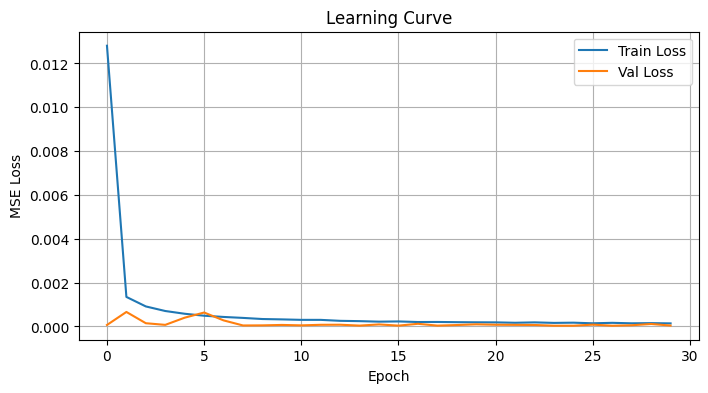

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

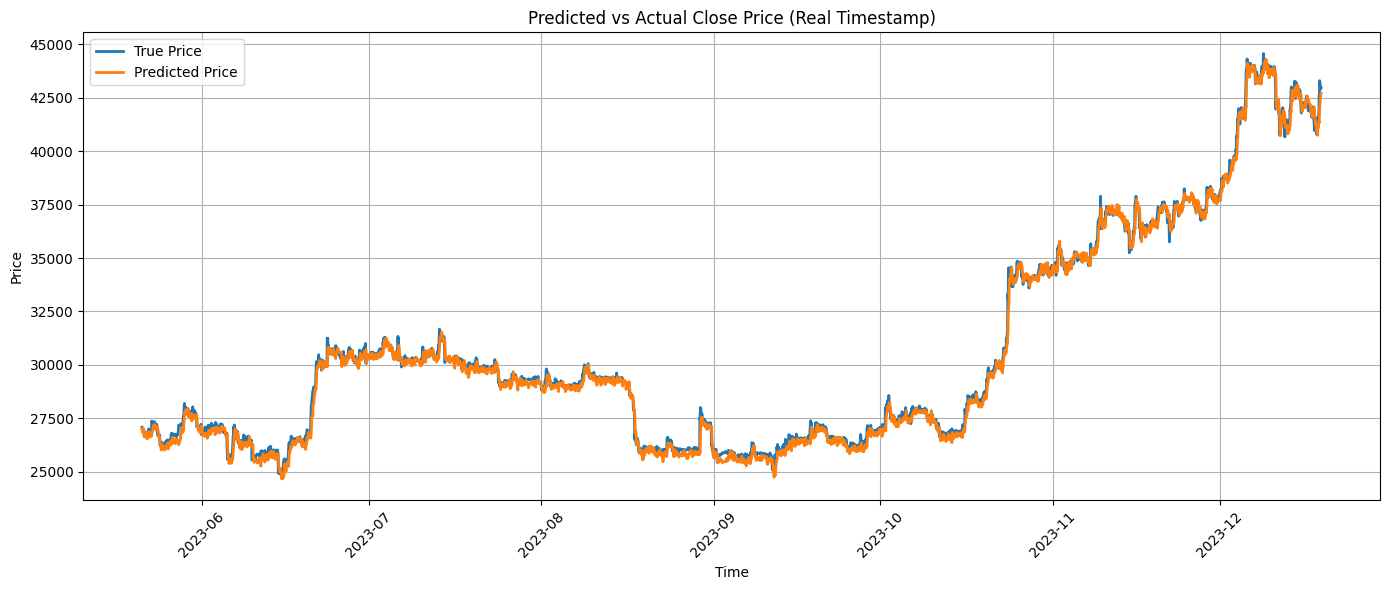

In [ ]:
test_timestamps = test_df['date_hour'].values
test_seq_timestamps = test_timestamps[seq_len:]

plt.figure(figsize=(14,6))
plt.plot(test_seq_timestamps, y_true_price, label='True Price', linewidth=2)
plt.plot(test_seq_timestamps, pred_price, label='Predicted Price', linewidth=2)

plt.title("Predicted vs Actual Close Price (Real Timestamp)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse_norm = mean_squared_error(y_test_seq, pred_norm)
mse_real = mean_squared_error(y_true_price, pred_price)

rmse = np.sqrt(mse_real)
mae  = np.mean(np.abs(y_true_price - pred_price))
mape = np.mean(np.abs((y_true_price - pred_price) / y_true_price)) * 100
acc  = 1 - mape/100   # vs paper

print("Normalized MSE:", mse_norm)
print("Real Price MSE:", mse_real)
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE(%):", mape)
print("Accuracy:", acc)


Normalized MSE: 2.7894262409415358e-05
Real Price MSE: 78144.19476609273
RMSE: 279.54283172010105
MAE: 206.6159836787245
MAPE(%): 0.6856298920710796
Accuracy: 0.9931437010792892


**Predict Retrurn**

In [ ]:
df['target_ret'] = df['close'].pct_change().shift(-1)
df = df.dropna().reset_index(drop=True)

In [ ]:
total_len = len(df)
train_end = int(total_len * 0.7)

train_df = df.iloc[:train_end]
test_df  = df.iloc[train_end:]

sub_end = int(len(train_df) * 0.9)
subtrain_df = train_df.iloc[:sub_end]
val_df      = train_df.iloc[sub_end:]
scaler_price = MinMaxScaler()
scaler_price.fit(subtrain_df[price_cols])

sub_price  = scaler_price.transform(subtrain_df[price_cols])
val_price  = scaler_price.transform(val_df[price_cols])
test_price = scaler_price.transform(test_df[price_cols])

sub_emb  = subtrain_df[emb_cols].values * 0.01
val_emb  = val_df[emb_cols].values * 0.01
test_emb = test_df[emb_cols].values * 0.01

X_sub_df  = np.concatenate([sub_price,  sub_emb],  axis=1)
X_val_df  = np.concatenate([val_price,  val_emb],  axis=1)
X_test_df = np.concatenate([test_price, test_emb], axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler_ret = StandardScaler()
scaler_ret.fit(subtrain_df[['target_ret']])

y_sub  = scaler_ret.transform(subtrain_df[['target_ret']]).reshape(-1)
y_val  = scaler_ret.transform(val_df[['target_ret']]).reshape(-1)
y_test = scaler_ret.transform(test_df[['target_ret']]).reshape(-1)

In [ ]:
X_sub,  y_sub_seq  = build_sequences(X_sub_df,  y_sub,  seq_len=12)
X_val,  y_val_seq  = build_sequences(X_val_df,  y_val,  seq_len=12)
X_test, y_test_seq = build_sequences(X_test_df, y_test, seq_len=12)

In [ ]:
X_train_all = np.concatenate([X_sub, X_val], axis=0)
y_train_all = np.concatenate([y_sub_seq, y_val_seq], axis=0)

model, train_losses, val_losses = train_transformer(
    X_train_all,
    y_train_all,
    lr=1e-4,
    batch_size=32,
    epochs=30
)

pred_norm = predict(model, X_test)
pred_ret = scaler_ret.inverse_transform(pred_norm.reshape(-1,1)).reshape(-1)

Epoch 01 | Train Loss 1.025055 | Val Loss 0.558213
Epoch 02 | Train Loss 1.028093 | Val Loss 0.557993
Epoch 03 | Train Loss 1.023346 | Val Loss 0.559547
Epoch 04 | Train Loss 1.024934 | Val Loss 0.555047
Epoch 05 | Train Loss 1.022160 | Val Loss 0.554299
Epoch 06 | Train Loss 1.021192 | Val Loss 0.560137
Epoch 07 | Train Loss 1.024054 | Val Loss 0.554160
Epoch 08 | Train Loss 1.021012 | Val Loss 0.560035
Epoch 09 | Train Loss 1.022807 | Val Loss 0.558191
Epoch 10 | Train Loss 1.019739 | Val Loss 0.555922
Epoch 11 | Train Loss 1.022609 | Val Loss 0.555089
Epoch 12 | Train Loss 1.024522 | Val Loss 0.556096
Epoch 13 | Train Loss 1.074278 | Val Loss 0.554360
Epoch 14 | Train Loss 1.022280 | Val Loss 0.556318
Epoch 15 | Train Loss 1.028927 | Val Loss 0.556889
Epoch 16 | Train Loss 1.020723 | Val Loss 0.554141
Epoch 17 | Train Loss 1.021372 | Val Loss 0.555966
Epoch 18 | Train Loss 1.021515 | Val Loss 0.554216
Epoch 19 | Train Loss 1.021944 | Val Loss 0.555945
Epoch 20 | Train Loss 1.023450 

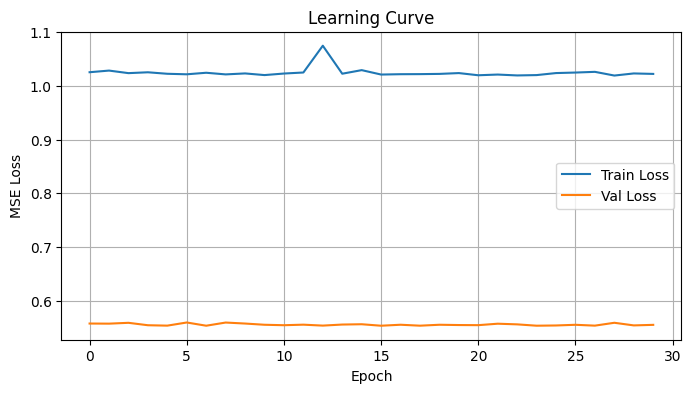

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

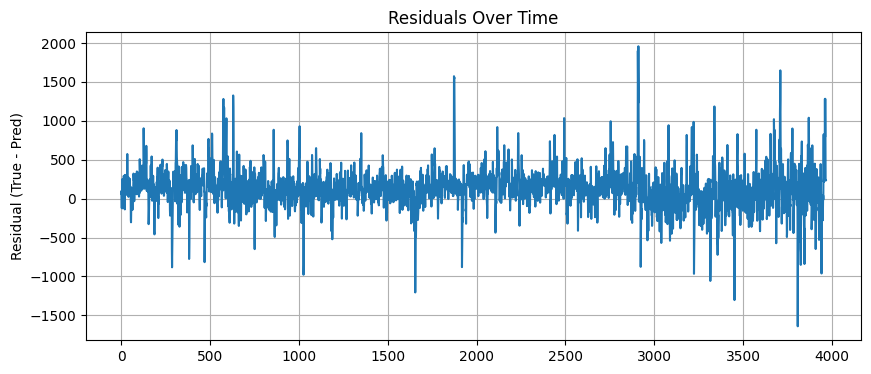

In [ ]:
residuals = y_true_price - pred_price

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.ylabel("Residual (True - Pred)")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

print("Return MSE:", mean_squared_error(y_test_seq, pred_norm))
print("Return R2:", r2_score(y_test_seq, pred_norm))

Return MSE: 0.2716944426545056
Return R2: -0.01020100809406399


**Classify Up_Down**

In [ ]:
df['return'] = df['close'].pct_change()
df['label'] = (df['return'] > 0).astype(int)
df = df.dropna().reset_index(drop=True)

In [ ]:
total_len = len(df)
train_end = int(total_len * 0.7)

train_df = df.iloc[:train_end]
test_df  = df.iloc[train_end:]

sub_end = int(len(train_df) * 0.9)
subtrain_df = train_df.iloc[:sub_end]
val_df      = train_df.iloc[sub_end:]

price_cols = ['open', 'high', 'low', 'close']
emb_cols   = [c for c in df.columns if c.startswith("emb_")]

# --- price scaler ---
scaler_price = MinMaxScaler()
scaler_price.fit(subtrain_df[price_cols])

sub_price  = scaler_price.transform(subtrain_df[price_cols])
val_price  = scaler_price.transform(val_df[price_cols])
test_price = scaler_price.transform(test_df[price_cols])

# --- embedding (scale ×0.01) ---
sub_emb  = subtrain_df[emb_cols].values * 0.01
val_emb  = val_df[emb_cols].values * 0.01
test_emb = test_df[emb_cols].values * 0.01

# --- combine ---
X_sub_df  = np.concatenate([sub_price,  sub_emb],  axis=1)
X_val_df  = np.concatenate([val_price,  val_emb],  axis=1)
X_test_df = np.concatenate([test_price, test_emb], axis=1)

# --- labels (classification) ---
y_sub  = subtrain_df['label'].values
y_val  = val_df['label'].values
y_test = test_df['label'].values

In [ ]:
def build_sequences(X_block, y_block, seq_len=12):
    X_list, y_list = [], []

    for i in range(seq_len, len(X_block)):
        X_list.append(X_block[i-seq_len:i])
        y_list.append(y_block[i])

    return np.array(X_list), np.array(y_list)

seq_len = 12

X_sub,  y_sub_seq  = build_sequences(X_sub_df,  y_sub,  seq_len)
X_val,  y_val_seq  = build_sequences(X_val_df,  y_val,  seq_len)
X_test, y_test_seq = build_sequences(X_test_df, y_test, seq_len)

print("Shapes:")
print("Train:", X_sub.shape, y_sub_seq.shape)
print("Val:",   X_val.shape, y_val_seq.shape)
print("Test:",  X_test.shape, y_test_seq.shape)

Shapes:
Train: (8342, 12, 772) (8342,)
Val: (917, 12, 772) (917,)
Test: (3967, 12, 772) (3967,)


In [ ]:
model = train_classifier(
    X_sub, y_sub_seq,
    X_val, y_val_seq,
    lr=1e-4,
    epochs=20,
    batch_size=32
)


Epoch 1/20 | Val Loss = 0.6983
Epoch 2/20 | Val Loss = 0.7057
Epoch 3/20 | Val Loss = 0.7045
Epoch 4/20 | Val Loss = 0.6938
Epoch 5/20 | Val Loss = 0.6930
Epoch 6/20 | Val Loss = 0.6975
Epoch 7/20 | Val Loss = 0.6930
Epoch 8/20 | Val Loss = 0.6945
Epoch 9/20 | Val Loss = 0.6962
Epoch 10/20 | Val Loss = 0.7038
Epoch 11/20 | Val Loss = 0.6945
Epoch 12/20 | Val Loss = 0.6934
Epoch 13/20 | Val Loss = 0.7006
Epoch 14/20 | Val Loss = 0.6994
Epoch 15/20 | Val Loss = 0.6982
Epoch 16/20 | Val Loss = 0.6949
Epoch 17/20 | Val Loss = 0.6955
Epoch 18/20 | Val Loss = 0.6938
Epoch 19/20 | Val Loss = 0.6941
Epoch 20/20 | Val Loss = 0.6953


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

model.eval()
device = next(model.parameters()).device

with torch.no_grad():
    logits = model(torch.tensor(X_test, dtype=torch.float32).to(device))
    prob = torch.sigmoid(logits).cpu().numpy()
    pred_label = (prob > 0.5).astype(int)

acc = accuracy_score(y_test_seq, pred_label)
auc = roc_auc_score(y_test_seq, prob)

print("Test Accuracy:", acc)
print("Test AUC:", auc)


Test Accuracy: 0.5046634736576758
Test AUC: 0.506414324396476
